In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfReflectiveGRUCell(nn.Module):
    def __init__(self, input_dim, latent_dim, history_len=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.gru = nn.GRUCell(input_dim, latent_dim)
        self.lat_pred = nn.Linear(latent_dim + input_dim, latent_dim)
        self.attn_weights = nn.Parameter(torch.randn(history_len))  # Learnable attention over history
        self.history_len = history_len

        # Buffers for state + error history
        self.register_buffer('state_history', torch.zeros(history_len, latent_dim))
        self.register_buffer('error_history', torch.zeros(history_len))
        self.time_index = 0

    def forward(self, x_t, z_t):
        # Predict latent state from input + current latent
        z_hat = self.lat_pred(torch.cat([x_t, z_t], dim=-1))

        # Actual GRU transition
        z_next = self.gru(x_t, z_t)

        # Prediction error
        prediction_error = F.mse_loss(z_next, z_hat, reduction='none').mean(dim=-1)

        # Store history (circular buffer)
        idx = self.time_index % self.history_len
        self.state_history[idx] = z_next.detach()
        self.error_history[idx] = prediction_error.detach()
        self.time_index += 1

        # Attention over latent history
        attn_scores = F.softmax(self.attn_weights, dim=0)
        memory_summary = torch.sum(attn_scores.view(-1, 1) * self.state_history, dim=0)

        # Combine GRU output with memory summary
        z_combined = z_next + memory_summary

        return z_combined, z_next, z_hat, prediction_error


In [ ]:
input_dim = 4
latent_dim = 8
model = SelfReflectiveGRUCell(input_dim, latent_dim)

x_t = torch.randn(1, input_dim)
z_t = torch.zeros(1, latent_dim)

z_combined, z_next, z_hat, prediction_error = model(x_t, z_t)

print("z_combined:", z_combined)
print("z_next:", z_next)
print("z_hat:", z_hat)
print("prediction_error:", prediction_error)

z_combined: tensor([[-0.0482,  0.0921,  0.0564,  0.0601,  0.0316,  0.1236,  0.1925, -0.2556]],
       grad_fn=<AddBackward0>)
z_next: tensor([[-0.0469,  0.0896,  0.0548,  0.0584,  0.0308,  0.1201,  0.1871, -0.2484]],
       grad_fn=<AddBackward0>)
z_hat: tensor([[-0.1033, -0.0986, -0.2970, -0.2166, -0.2886,  0.0038, -0.2112, -0.2710]],
       grad_fn=<AddmmBackward0>)
prediction_error: tensor([0.0641], grad_fn=<MeanBackward1>)


In [3]:
class SwarmReflectiveAgents(nn.Module):
    def __init__(self, num_agents, input_dim, latent_dim, history_len=10, comm_threshold=0.1):
        super().__init__()
        self.agents = nn.ModuleList([
            SelfReflectiveGRUCell(input_dim, latent_dim, history_len)
            for _ in range(num_agents)
        ])
        self.latent_dim = latent_dim
        self.comm_threshold = comm_threshold

    def forward(self, x_t_batch, z_t_batch):
        new_states = []
        divergences = []

        # Each agent updates independently
        for i, agent in enumerate(self.agents):
            z_combined, z_next, z_hat, error = agent(x_t_batch[i], z_t_batch[i])
            new_states.append(z_next)
            divergences.append((z_next - z_hat).norm().item())

        new_states = torch.stack(new_states)

        # Inter-agent communication based on similarity
        z_comm = new_states.clone()
        for i in range(len(self.agents)):
            neighbors = []
            for j in range(len(self.agents)):
                if i != j and (new_states[i] - new_states[j]).norm() < self.comm_threshold:
                    neighbors.append(new_states[j])
            if neighbors:
                z_avg = torch.stack(neighbors).mean(dim=0)
                z_comm[i] = (new_states[i] + z_avg) / 2

        return z_comm, divergences


In [4]:
# Set dimensions and number of agents
input_dim, latent_dim, num_agents = 4, 8, 3
swarm = SwarmReflectiveAgents(num_agents, input_dim, latent_dim)

# Dummy input batch (one per agent)
x_batch = torch.randn(num_agents, input_dim)
z_batch = torch.zeros(num_agents, latent_dim)

# Forward pass through swarm
z_comm, divergences = swarm(x_batch, z_batch)

print("New communicated states:", z_comm)
print("Prediction divergences:", divergences)


New communicated states: tensor([[-0.1917, -0.1468, -0.1387, -0.0812,  0.2226,  0.1163, -0.1243,  0.0662],
        [ 0.1151, -0.0393, -0.4759,  0.0079,  0.0938,  0.1514, -0.0132, -0.0723],
        [ 0.1361,  0.0235, -0.1647,  0.0807, -0.1261,  0.0354, -0.0412, -0.1453]],
       grad_fn=<CloneBackward0>)
Prediction divergences: [0.9653360247612, 1.2869700193405151, 0.7733148336410522]


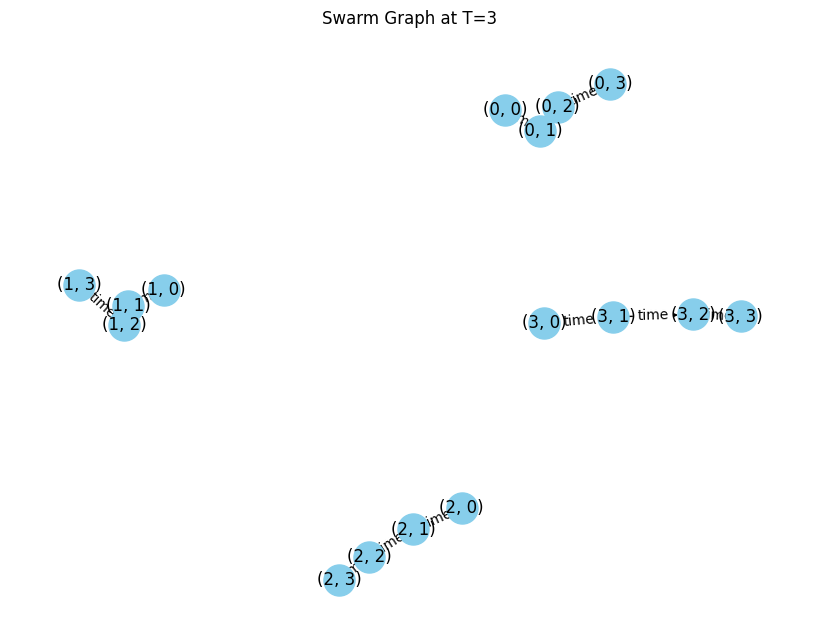

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
class SwarmGraph(nn.Module):
    def __init__(self, num_agents, input_dim, latent_dim, history_len=10, comm_threshold=0.5):
        super().__init__()
        self.agents = nn.ModuleList([
            SelfReflectiveGRUCell(input_dim, latent_dim, history_len)
            for _ in range(num_agents)
        ])
        self.graph = nx.DiGraph()
        for i in range(num_agents):
            self.graph.add_node((i, 0))

        self.comm_threshold = comm_threshold
        self.latent_dim = latent_dim
        self.time_step = 0
        self.z_prev = [torch.zeros(latent_dim) for _ in range(num_agents)]

    def forward(self, x_t_batch):
        z_next_list = []

        for i, agent in enumerate(self.agents):
            _, z_next, z_hat, _ = agent(x_t_batch[i], self.z_prev[i])
            z_next_list.append(z_next)

        for i in range(len(self.agents)):
            self.graph.add_node((i, self.time_step + 1))
            self.graph.add_edge((i, self.time_step), (i, self.time_step + 1), label="time")

        for i in range(len(self.agents)):
            for j in range(i + 1, len(self.agents)):
                dist = (z_next_list[i] - z_next_list[j]).norm().item()
                if dist < self.comm_threshold:
                    self.graph.add_edge((i, self.time_step + 1), (j, self.time_step + 1), weight=1.0 - dist, label="comm")
                    self.graph.add_edge((j, self.time_step + 1), (i, self.time_step + 1), weight=1.0 - dist, label="comm")

        new_z = []
        for i in range(len(self.agents)):
            node = (i, self.time_step + 1)
            neighbors = list(self.graph.predecessors(node))
            if neighbors:
                z_sum = z_next_list[i]
                for j_node in neighbors:
                    if j_node[0] != i:
                        z_sum += z_next_list[j_node[0]]
                new_z.append(z_sum / (len(neighbors) + 1))
            else:
                new_z.append(z_next_list[i])

        self.z_prev = new_z
        self.time_step += 1
        return self.graph

    def draw_graph(self):
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(self.graph, seed=42)
        edge_labels = nx.get_edge_attributes(self.graph, "label")
        nx.draw(self.graph, pos, with_labels=True, node_size=500, node_color="skyblue", arrows=True)
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels)
        plt.title(f"Swarm Graph at T={self.time_step}")
        plt.show()


# Initialize and simulate swarm behavior
input_dim, latent_dim, num_agents = 4, 8, 4
swarm = SwarmGraph(num_agents, input_dim, latent_dim)

for _ in range(3):  # simulate 3 timesteps
    x_batch = torch.randn(num_agents, input_dim)
    graph = swarm(x_batch)

swarm.draw_graph()

In [6]:
import numpy as np
from itertools import combinations
def estimate_graph_curvature(graph, latent_states, timestep):
    """
    Estimate graph curvature at a given timestep.
    Looks at triangle inequality violations and loop inconsistencies.
    """
    triangle_violations = []
    nodes = [(i, timestep) for i in range(len(latent_states))]
    node_to_latent = {node: latent_states[i] for i, node in enumerate(nodes)}

    for triplet in combinations(nodes, 3):
        a, b, c = triplet
        za, zb, zc = node_to_latent[a], node_to_latent[b], node_to_latent[c]

        d_ab = torch.norm(za - zb).item()
        d_bc = torch.norm(zb - zc).item()
        d_ca = torch.norm(zc - za).item()

        # Triangle inequality violations
        if d_ab + d_bc < d_ca or d_bc + d_ca < d_ab or d_ca + d_ab < d_bc:
            triangle_violations.append((a, b, c))

    loop_scores = []
    for cycle in nx.simple_cycles(graph.to_directed()):
        if len(cycle) == 3:
            try:
                zs = [node_to_latent[(n[0], timestep)] for n in cycle]
                d_total = sum(torch.norm(zs[i] - zs[(i + 1) % 3]).item() for i in range(3))
                loop_scores.append(d_total)
            except KeyError:
                continue

    return {
        "triangle_violations": triangle_violations,
        "avg_loop_score": np.mean(loop_scores) if loop_scores else 0.0,
        "num_loops": len(loop_scores),
    }